# Important Economic Indicators on FRED

1. **Gross Domestic Product (GDP):** Measures the total value of goods and services produced in the country.
   - [GDP](https://fred.stlouisfed.org/series/GDP)
2. **Unemployment Rate:** Indicates the percentage of the labor force that is unemployed and actively seeking employment.
   - [UNRATE](https://fred.stlouisfed.org/series/UNRATE)
3. **Consumer Price Index (CPI):** Measures changes in the price level of a market basket of consumer goods and services purchased by households.
   - [CPIAUCSL](https://fred.stlouisfed.org/series/CPIAUCSL)
4. **Producer Price Index (PPI):** Measures the average change over time in the selling prices received by domestic producers for their output.
   - [PPIACO](https://fred.stlouisfed.org/series/PPIACO)
5. **Federal Funds Rate:** The interest rate at which depository institutions trade federal funds with each other overnight.
   - [FEDFUNDS](https://fred.stlouisfed.org/series/FEDFUNDS)
6. **Personal Consumption Expenditures (PCE):** Measures the value of goods and services purchased by households.
   - [PCE](https://fred.stlouisfed.org/series/PCE)
7. **Industrial Production Index:** Measures the real output of all relevant establishments located in the United States.
   - [INDPRO](https://fred.stlouisfed.org/series/INDPRO)
8. **Retail Sales:** Tracks the total receipts of retail stores, providing a gauge of consumer spending.
   - [RSAFS](https://fred.stlouisfed.org/series/RSAFS)
9. **Nonfarm Payrolls:** Reports the total number of paid U.S. workers of any business, excluding government, non-profit, private household, and farm employees.
   - [PAYEMS](https://fred.stlouisfed.org/series/PAYEMS)

---

#### Import Python tools and Jupyter config

In [1]:
import os
import altair as alt
import pandas as pd
import jupyter_black
from fredapi import Fred
import matplotlib.pyplot as plt

jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

today = pd.Timestamp("today").strftime("%Y-%m-%d")

---

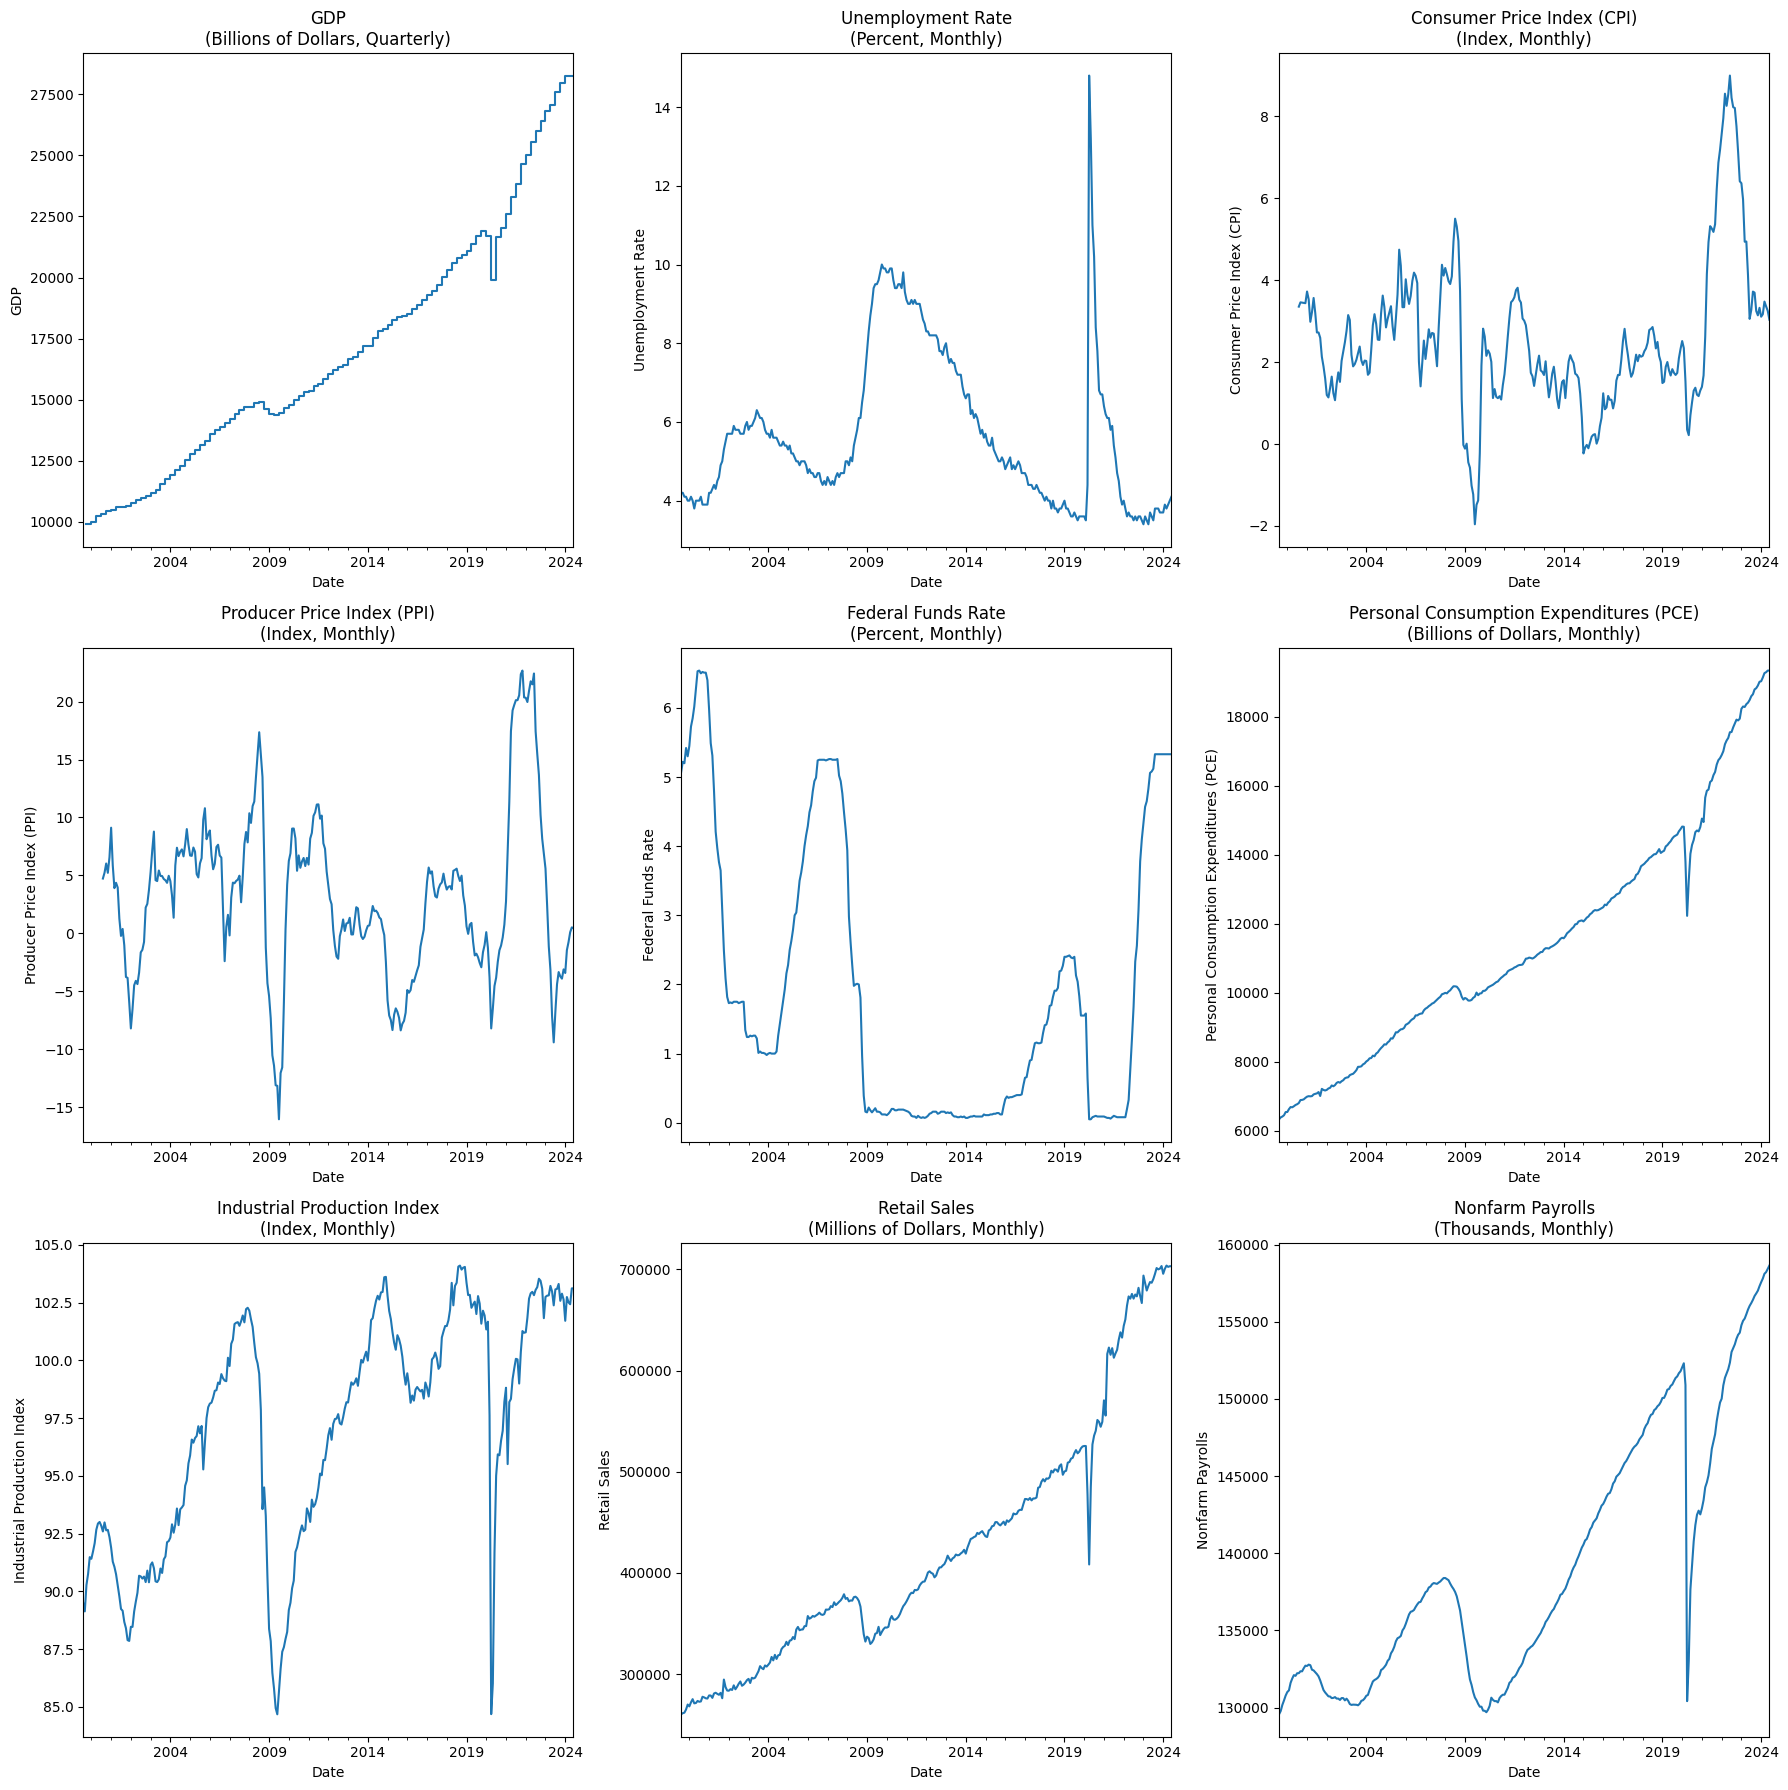

In [2]:
# FRED API key
fred_api_key = os.environ.get("fred_api")

# Check if the API key is provided
if not fred_api_key:
    raise ValueError(
        "FRED API key is not provided. Please set the fred_api_key variable."
    )

# Initialize the Fred object
try:
    fred = Fred(api_key=fred_api_key)
except Exception as e:
    print(f"Error initializing FRED object: {e}")
    raise

# List of indicators and their FRED endpoints
indicators = {
    "GDP": "GDP",
    "Unemployment Rate": "UNRATE",
    "Consumer Price Index (CPI)": "CPIAUCSL",
    "Producer Price Index (PPI)": "PPIACO",
    "Federal Funds Rate": "FEDFUNDS",
    "Personal Consumption Expenditures (PCE)": "PCE",
    "Industrial Production Index": "INDPRO",
    "Retail Sales": "RSAFS",
    "Nonfarm Payrolls": "PAYEMS",
}

# Units and frequencies for the indicators
units = {
    "GDP": "Billions of Dollars, Quarterly",
    "Unemployment Rate": "Percent, Monthly",
    "Consumer Price Index (CPI)": "Index, Monthly",
    "Producer Price Index (PPI)": "Index, Monthly",
    "Federal Funds Rate": "Percent, Monthly",
    "Personal Consumption Expenditures (PCE)": "Billions of Dollars, Monthly",
    "Industrial Production Index": "Index, Monthly",
    "Retail Sales": "Millions of Dollars, Monthly",
    "Nonfarm Payrolls": "Thousands, Monthly",
}

# Fetch data for the last 25 years or as far back as they go
data_frames = {}
for name, series_id in indicators.items():
    try:
        # Fetch the data from FRED
        series_data = fred.get_series(series_id)
        if series_data is None:
            print(f"Failed to fetch data for {name} with series ID {series_id}")
            continue
        # Filter for the last 25 years
        filtered_data = series_data[
            series_data.index >= pd.Timestamp.now() - pd.DateOffset(years=25)
        ]
        # Store in the dictionary with the correct name
        data_frames[name] = filtered_data.to_frame(name)
    except Exception as e:
        print(f"Error fetching data for {name}: {e}")

# Concatenate all data into a single DataFrame
if data_frames:
    data = pd.concat(data_frames.values(), axis=1)

    # Handle missing values (e.g., forward fill for quarterly data)
    data["GDP"] = data["GDP"].ffill()
    data.ffill(inplace=True)

    # Display the first few rows of the combined DataFrame
    # print(data.head())

    # Save each indicator to a separate CSV file
    for name in indicators:
        if name in data:
            data[name].to_csv(
                f"{name.replace(' ', '_').lower()}_last_25_years.csv", header=[name]
            )

    # Plot each indicator in a 3x3 grid with units and frequency as subheads
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
    axes = axes.flatten()

    for i, (name, series_id) in enumerate(indicators.items()):
        ax = axes[i]
        if name in data:
            if name in ["Consumer Price Index (CPI)", "Producer Price Index (PPI)"]:
                # Calculate annual change by month
                annual_change = data[name].pct_change(periods=12) * 100
                annual_change.plot(
                    ax=ax, title=f"{name}\n({units[name]})", ylabel="Annual % Change"
                )
            elif name == "GDP":
                data[name].plot(
                    ax=ax, title=f"{name}\n({units[name]})", drawstyle="steps-post"
                )
            else:
                data[name].plot(ax=ax, title=f"{name}\n({units[name]})")
            ax.set_xlabel("Date")
            ax.set_ylabel(name)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

else:
    print("No data fetched for any indicators.")